### Galaxy Stellar Mass Function

Plot the galaxy stellar mass function for each of our selections:

- $\mathrm{S_{SFR1}}$ 
- $\mathrm{S_{SFR5}}$ 
- $\mathrm{S_{MAS9}}$ 
- $\mathrm{S_{MAS10}}$ 


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

h = 0.673
L = 480.279 /h  # box length

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'  # input data directory
out_directory = 'output/'   # output image directory

Load the galaxy data for all selections at all redshifts

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

In [3]:
gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')
    

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97
6 8p22
7 8p93
8 9p72


Factor in $h$ dependence

In [4]:
for i, z in enumerate(redshifts):
    gals_sfr[i][['z0_central_mcrit200','zn_stellarMass']] /= h
    gals_mstar[i][['z0_central_mcrit200','zn_stellarMass']] /= h
    

Plot the mass function. $\mathrm{S_{SFR5}}$ is conditioned and masked within the redshift loop.

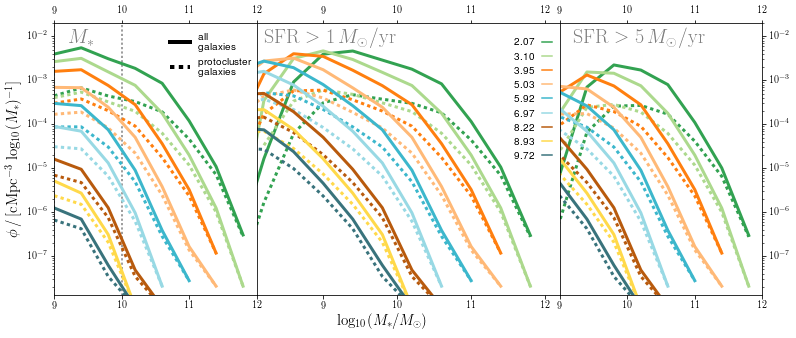

In [7]:
binLimits = np.linspace(6.8, 12.8, 16)
bins = np.linspace(7, 12.6, 15)
#print binLimits, bins

fig = plt.figure(figsize=(14.5,5))

gs = gridspec.GridSpec(1,24)

gs.update(wspace=0)

ax1 = fig.add_subplot(gs[0,0:6])
ax2 = fig.add_subplot(gs[0,6:15])
ax3 = fig.add_subplot(gs[15:21])

for ax, galaxy in zip([ax1, ax2, ax3],[gals_mstar, gals_sfr, gals_sfr]):
    
    for i, (gals,z) in enumerate(zip(galaxy, zees)):
        
        if ax == ax3:  # SFR5 mask
            mask = gals['zn_sfr'] > 5
        else:
            mask = np.array([True] * len(gals))
            

        phi, dummy = np.histogram(np.log10(gals[mask]['zn_stellarMass'] * 1e10), bins=binLimits)
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], label=z, linestyle='solid', linewidth=3)

        phi, dummy = np.histogram(np.log10(gals.loc[mask & (gals['z0_central_mcrit200'] > 1e4)]['zn_stellarMass'] \
                                           * 1e10), bins=binLimits)
        
        phi = (phi / L**3) / (binLimits[1] - binLimits[0])

        ax.semilogy(bins, phi, c=cmap[i], linestyle='dotted', linewidth=3)
        
        
ax1.text(1.4, -0.12, "$\mathrm{log_{10}}(M_* / M_{\odot})$", size=15, transform = ax1.transAxes)
ax1.set_ylabel("$\phi \,/\, [ \mathrm{cMpc^{-3}} \; \mathrm{log_{10}}(M_{*})^{-1}]$", size=15)


ax1.set_xticks([9, 10, 11, 12])
ax2.set_xticks([8, 9, 10, 11, 12])
ax3.set_xticks([9, 10, 11, 12])

ax1.set_xlim(9, 12)
ax2.set_xlim(8.1, 12.2)
ax3.set_xlim(9, 12)

for ax in [ax1,ax2,ax3]:
    ax.set_ylim(1.3e-8, 2e-2)
    ax.tick_params(labeltop=True, top=True)

    
ax2.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')

ax3.yaxis.tick_right()

ax1.vlines(10, 1e-9, 1e-1, linestyle='dotted', color='grey')
ax1.vlines(9, 1e-9, 1e-1, linestyle='dotted', color='grey')

ax1.text(9.2, 6e-3, '$M_{*}$', color='grey', size=20)
ax2.text(8.2, 6e-3, '$\mathrm{SFR} > 1 \, M_{\odot} / \mathrm{yr}$', color='grey', size=20)
ax3.text(9.2, 6e-3, '$\mathrm{SFR} > 5 \, M_{\odot} / \mathrm{yr}$', color='grey', size=20)

line_z = []
for i in range(len(zees)):
    line_z.append(plt.Line2D((0,0.5),(0,0), color=cmap[i], linestyle='solid'))
    
    
leg = ax2.legend(handles=[line for line in line_z], labels=["%.2f"%z for z in zees], 
           prop={'size':10}, frameon=False, bbox_to_anchor=(0.82, 0.46), handlelength=1)


vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: 
    c._children.reverse() 
vp.align="right" 


line_all = plt.Line2D((0,1),(0,0), color='black', linestyle='solid', linewidth=4)
line_pcs = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=4)

ax1.legend(handles=[line_all, line_pcs], 
           labels=['all \n galaxies', 'protocluster \n galaxies'], 
           prop={'size':10}, frameon=False, bbox_to_anchor=(0.53, 1))


# fig.savefig(out_directory+'gsmf.png', dpi=300, bbox_inches='tight')